<a href="https://colab.research.google.com/github/Gus-1003/ISD_psb20232/blob/main/Pratica/Aula_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Da última vez, praticamos processamento com um sinal de EMG. Hoje, iremos praticar com um sinal de EEG captado aqui no instituto

In [1]:
# Se offline, comentar esta célula
!gdown '1zRzVdrsO2kVv7jT2nKUTvpTEEwappZx4'

Downloading...
From: https://drive.google.com/uc?id=1zRzVdrsO2kVv7jT2nKUTvpTEEwappZx4
To: /content/Pratica_2.npy
100% 3.93M/3.93M [00:00<00:00, 197MB/s]


# Bibliotecas e módulos necessários

Para uma visualização mais interessante para os trabalhos envolvendo sinais neurofisiológico humanos, estaremos utilizando a biblioteca [MNE](https://mne.tools/stable/index.html).

In [2]:
#@title Baixa MNE

%%capture
!pip install mne

In [3]:
import mne # Manipulação e Visualização de dados neurofisiológicos
import numpy as np # Álgebra
import pandas as pd # Manipulação de dados
import matplotlib # Manipulação dos parâmetros das figuras
import matplotlib.pyplot as plt # Visualização de dados
import seaborn as sns # Visualização de dados
from scipy.signal import butter,cheby1,bessel,ellip,iirnotch,filtfilt # Filtros
from scipy.signal import welch # PSD do sinal

# Dados

Desta vez, os dados de EEG são várias janelas com 3s de sinal em 16 canais. Como precisei de 3 dimensões para salvar as janelas ([nº janelas,nº amostras, nº canais]), salvei os dados num arquivo *.npy* (formato do numpy) já que o *.csv* é para quando os dados utilizam só duas dimensões.

Os dados de EMG correspondem a todas as janelas de uma sessão onde o voluntário iniciava um ciclo de marcha com o pé esquerdo.

In [4]:
eeg_windows = np.load('Pratica_2.npy')

In [5]:
print(f'Dimensões do eeg_janelas: {eeg_windows.shape}')
print(f'Nº de janelas: {eeg_windows.shape[0]}')
print(f'Nº de canais: {eeg_windows.shape[1]}')
print(f'Quantas amostras por canais: {eeg_windows.shape[2]}')

Dimensões do eeg_janelas: (20, 16, 1537)
Nº de janelas: 20
Nº de canais: 16
Quantas amostras por canais: 1537


Aqui já está preparado algumas informações que iremos utilizar no decorrer do notebook.

In [6]:
FS = 512
channels = ['Fp1','Fp2','F3','F4','FC1','FC2','C4','C3','Cz','CP2','CP1','P4','Pz','P3','O2','O1']
time = np.arange(0,3.0019,1/FS)
N = eeg_windows.shape[-1]

E vamos converter uma janela aleatória para um dataframe do pandas só para habituar trabalhar com dataframes.

---

**[Pergunta] o que faz aquele *.T* depois de selecionar a janela a ser convertida?**

In [7]:
eeg_window = pd.DataFrame(eeg_windows[18].T, columns=channels)
eeg_window.head()

,Fp1,Fp2,F3,F4,FC1,FC2,C4,C3,Cz,CP2,CP1,P4,Pz,P3,O2,O1
0,-33292.238281,-22029.835938,-17256.789062,-22275.392578,-17395.998047,-25336.232422,-9768.946289,-13017.237305,-16116.114258,-13395.704102,-15875.635742,-4982.422363,-11648.975586,-13388.282227,-6399.512207,-9383.497070
1,-33296.144531,-22034.083984,-17256.789062,-22274.416016,-17395.656250,-25340.089844,-9765.284180,-13019.678711,-16118.018555,-13397.120117,-15873.926758,-4980.029785,-11645.606445,-13387.500977,-6395.459473,-9377.491211
2,-33296.144531,-22034.083984,-17256.789062,-22274.416016,-17395.656250,-25340.089844,-9765.284180,-13019.678711,-16118.018555,-13397.120117,-15873.926758,-4980.029785,-11645.606445,-13387.500977,-6395.459473,-9377.491211
3,-33296.144531,-22034.083984,-17256.789062,-22274.416016,-17395.656250,-25340.089844,-9765.284180,-13019.678711,-16118.018555,-13397.120117,-15873.926758,-4980.029785,-11645.606445,-13387.500977,-6395.459473,-9377.491211
4,-33296.144531,-22034.083984,-17256.789062,-22274.416016,-17395.656250,-25340.089844,-9765.284180,-13019.678711,-16118.018555,-13397.120117,-15873.926758,-4980.029785,-11645.606445,-13387.500977,-6395.459473,-9377.491211


Até agora, foram deixadas ocultas as funções que implementam os filtros, mas desta vez vamos olhar a função do filtro passa-banda em toda sua glória.

---

**[Atividade:] descrevam a função do filtro passa-banda (quais são os parâmetros de entrada, quais são as saídas, o caminho lógico da função, etc)**

**[Pergunta:] todas os parâmetros de entrada são estritamente necessários?**

#Filtro......temporal

In [8]:
def bandpass_filter(signal,N=2,f_low=8,f_high=12,Fs=512,filter_type='butter',max_ripple=3):
  """
  Entradas
  -signal: sinal de EEG
  -N: ordem do filtro
  -f_low: frequência mínima do passa-banda
  -f_high: frequência máxima do passa-banda
  -Fs: frequência de amostragem
  -filter_type: tipo do filtro (butterworth, chebyshev, elíptico ou bessel)
  -max_ripple: ripple máximo para os filtros chebyshev e elípticos

  Saídas
  -filtered: array do sinal filtrado no formato [tempo,]
  """
  match filter_type:
    case 'butter':
      b,a = butter(N,[f_low,f_high],'bandpass',fs=Fs)
    case 'cheby':
      b,a = cheby1(N,max_ripple,[f_low,f_high],'bandpass',fs=Fs)
    case 'bessel':
      b,a = bessel(N,[f_low,f_high],'bandpass',fs=Fs,norm='mag')
    case 'ellip':
      b,a = ellip(N,max_ripple,max_ripple,[f_low,f_high],'bandpass',fs=Fs)

  filtered = filtfilt(b,a,signal,axis=0)
  return filtered

Vamos dar uma olhada no sinal de cada canal. Para criar vários plots dentro da mesma figura, estaremos utilizando o [*subplot()*](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html) do matplotlib.

Como podemos ver pelas figuras, as escalas estão muito diferentes de um canal para outro. Estas diferenças são por conta de ruídos na hora da captação e a artefatos (sinais biológicos indesejados).

---

**[Pergunta:] lembrando do [sistema 10-20](https://gvb-gelimed.com/wp-content/uploads/2023/01/EEG_10-10_system_with_additional_information-1-768x511.jpg) e analisando a figura abaixo, qual foi a região mais afetada por artefatos e por que?**

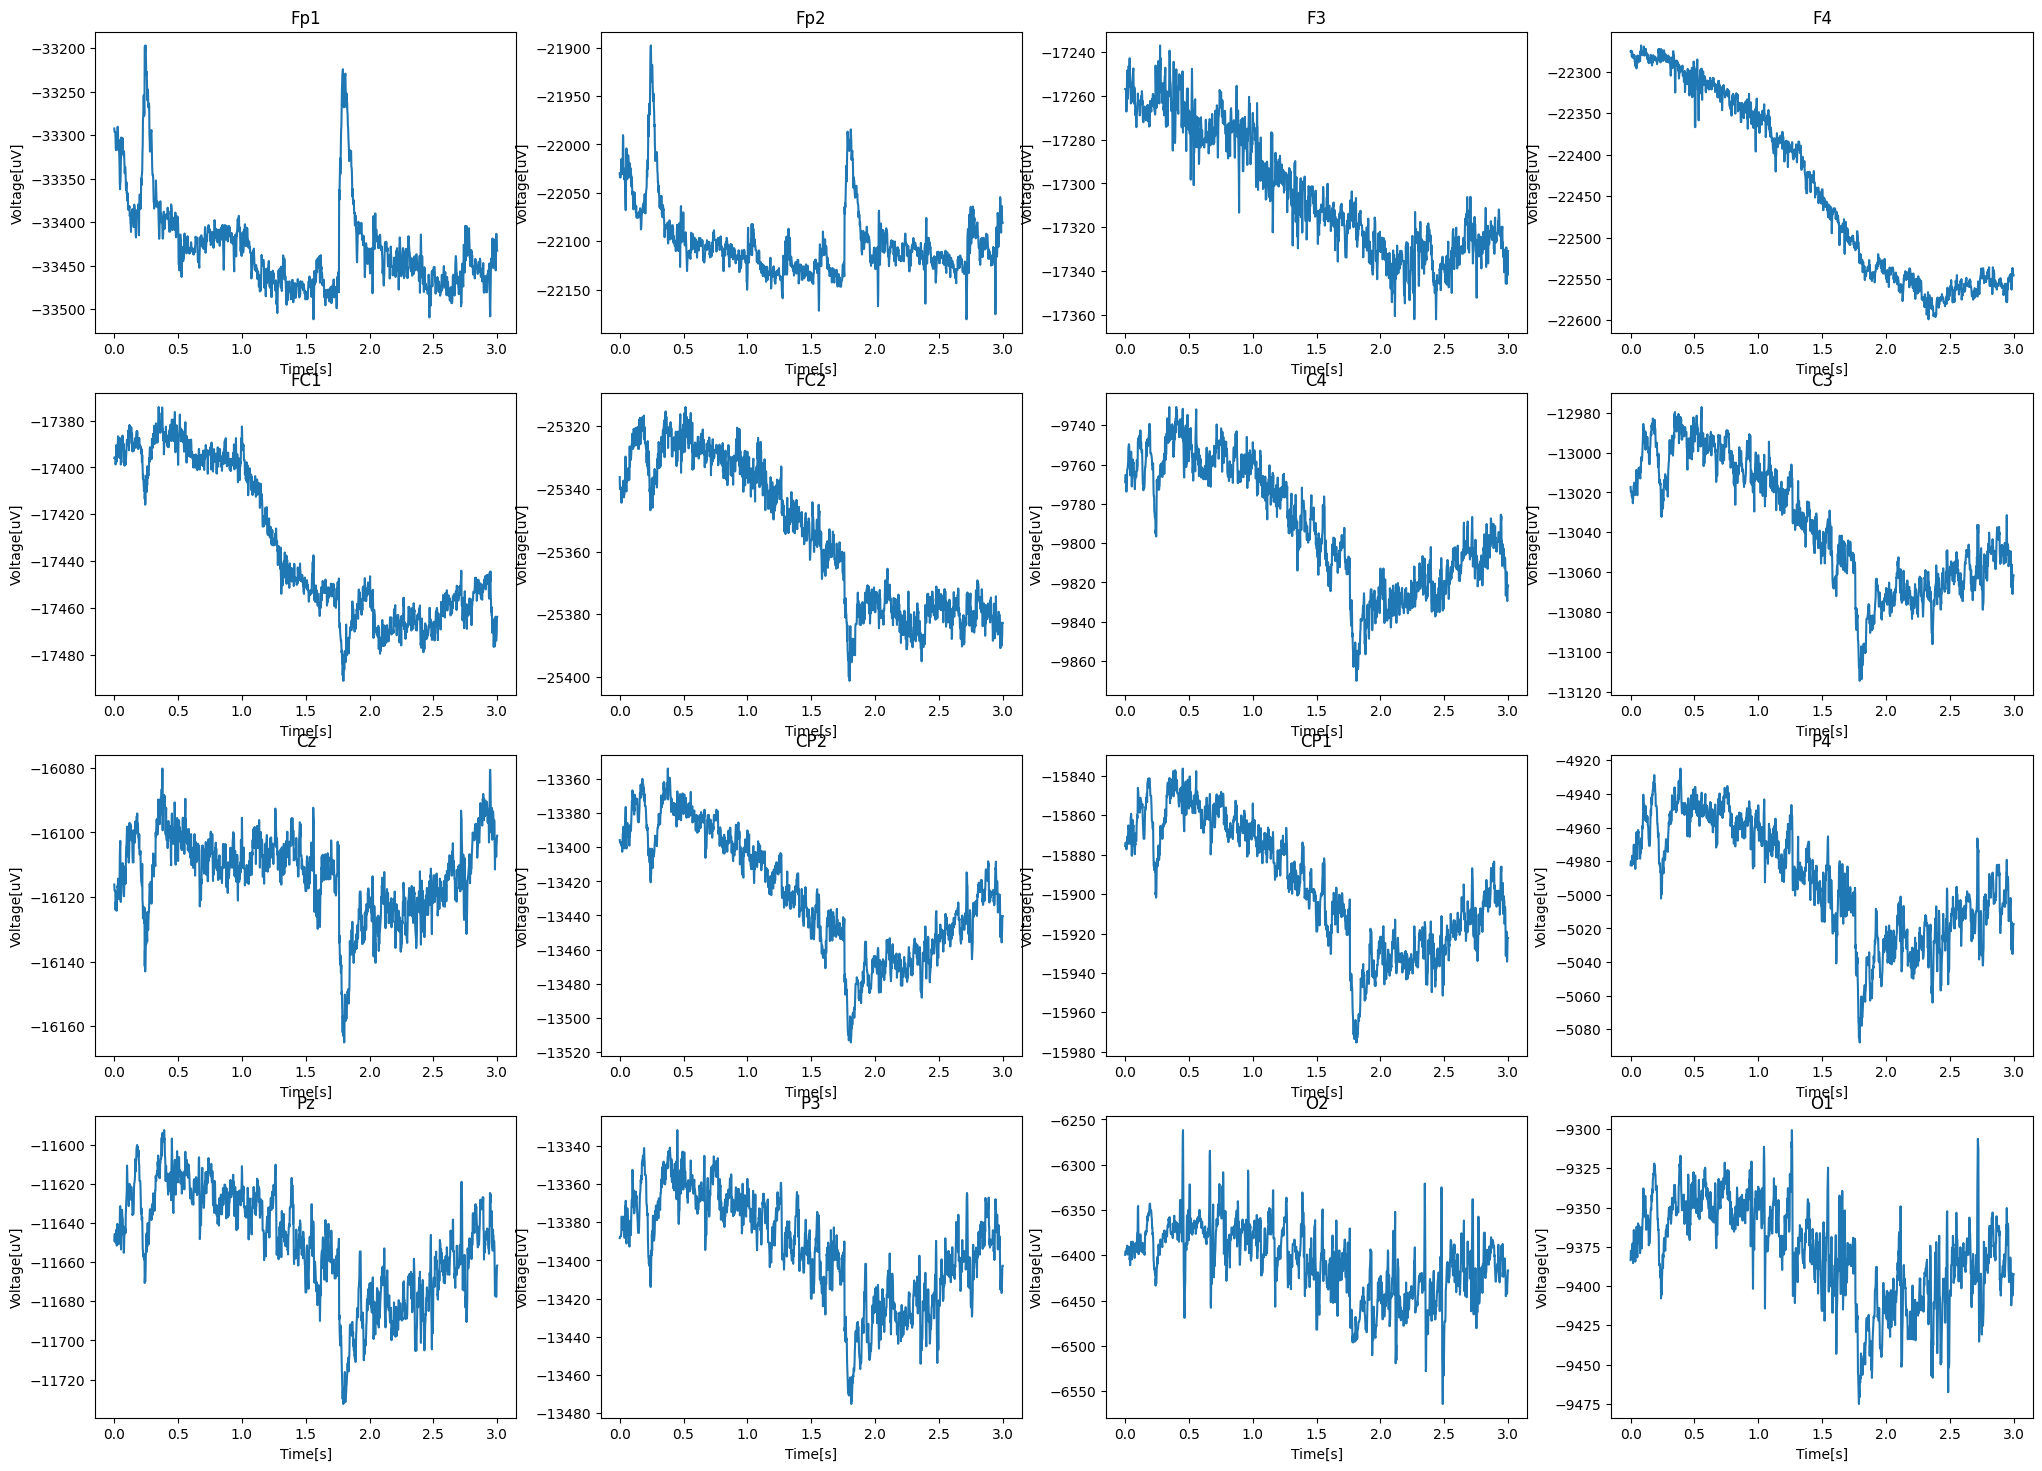

In [9]:
plt.figure(figsize=(25,18))
for idx,column in enumerate(eeg_window.columns):
  plt.subplot(4,4,idx+1)
  plt.plot(time,eeg_window[column])
  plt.xlabel('Time[s]')
  plt.ylabel('Voltage[uV]')
  plt.title(column)

plt.show()

Bem, agora chega a parte de processamento de sinais. Vamos filtrar todas as janelas com nosso filtro passa-banda através do método [*apply*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) do Pandas.

In [10]:
eeg_window_filtered = eeg_window.apply(bandpass_filter)

Percebam como mudou.

Geralmente é interessante fazer um plot comparando o sinal antes e depois da filtragem, mas neste caso nem é viável esse tipo de comparação por conta da diferença de escala dos valores do eixo y.

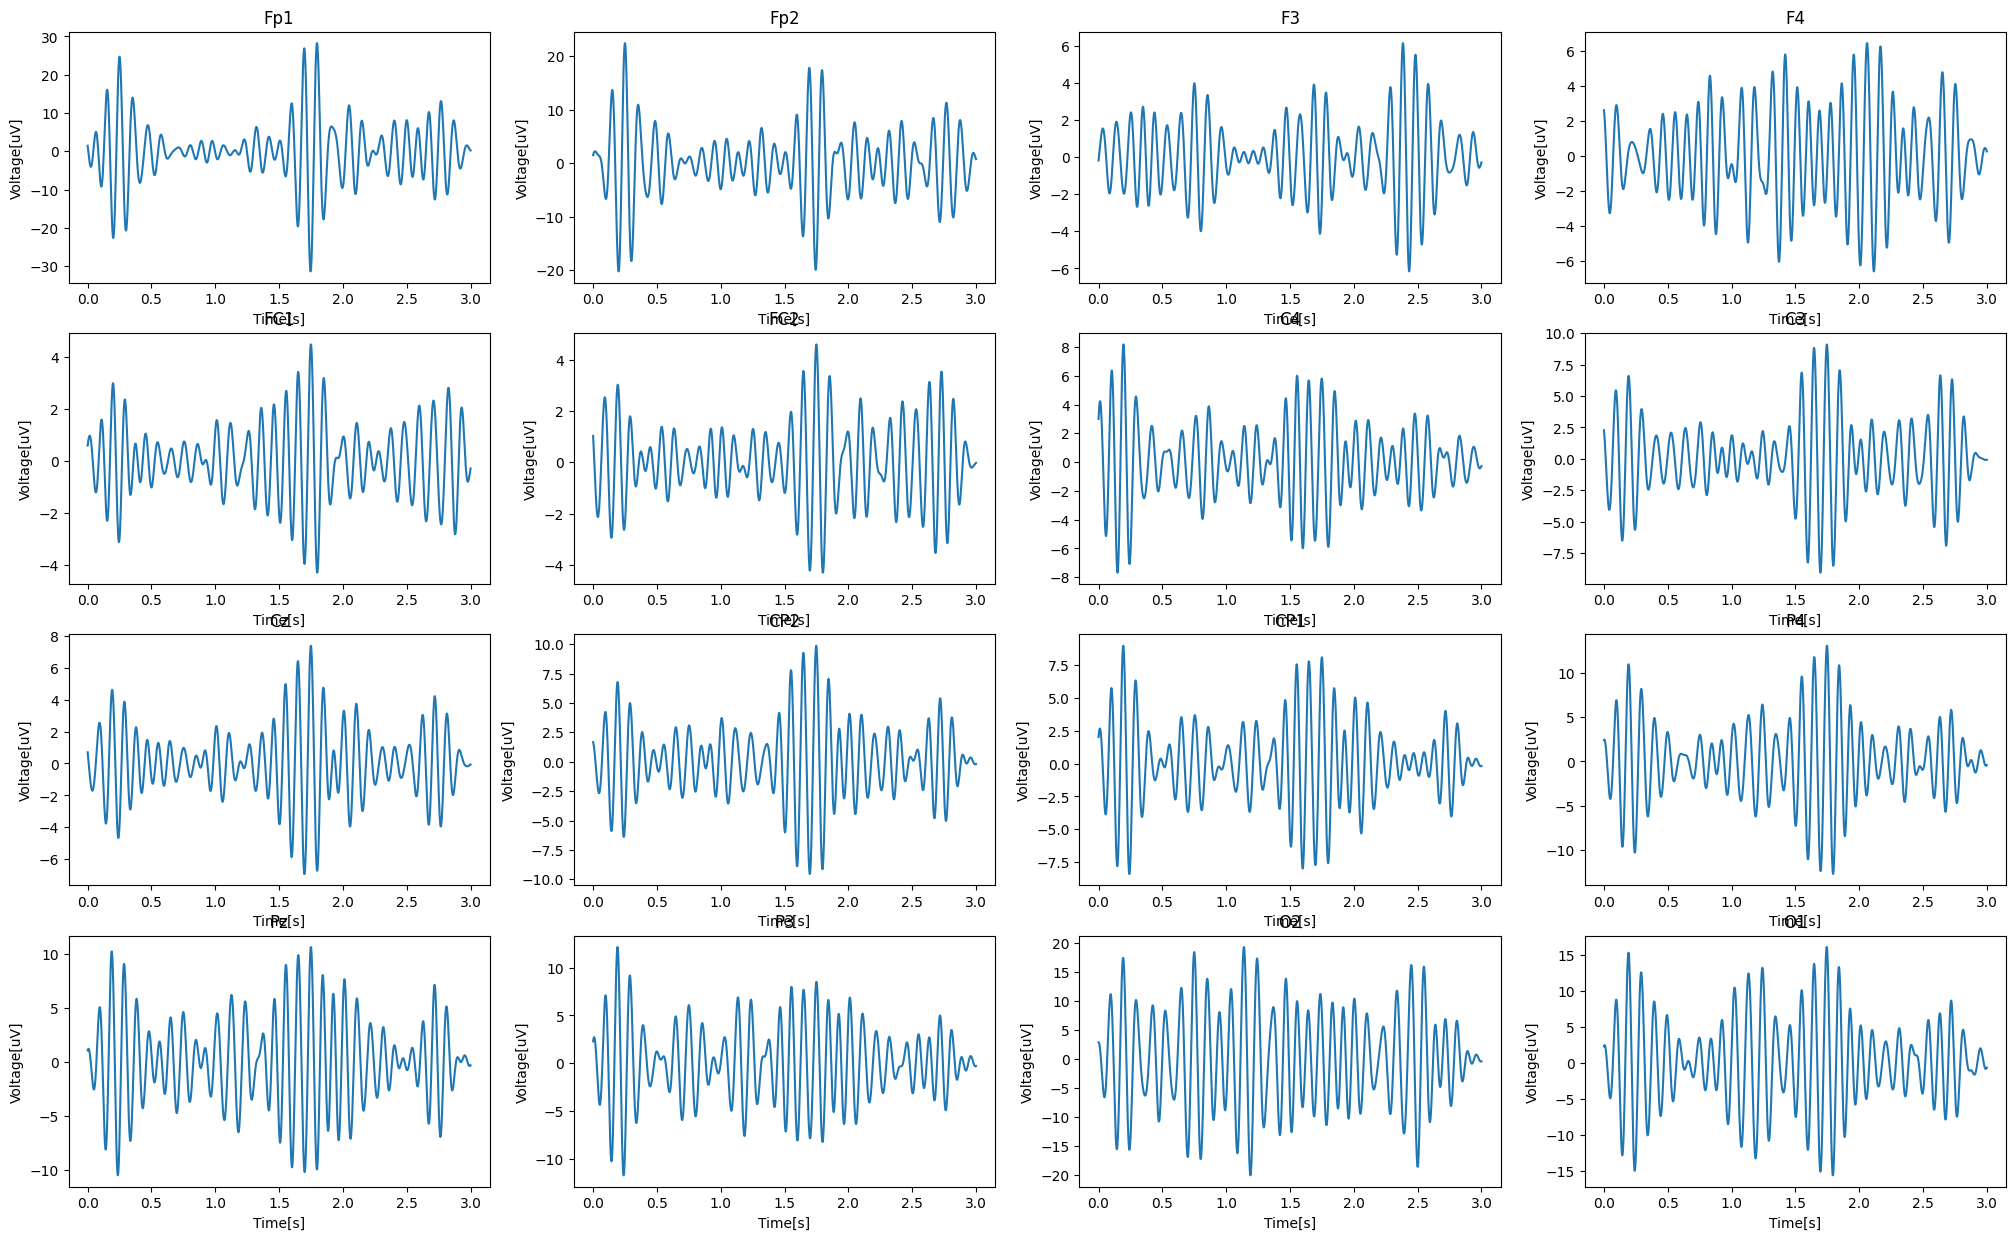

In [11]:
plt.figure(figsize=(25,15))
for idx,column in enumerate(eeg_window_filtered.columns):
  plt.subplot(4,4,idx+1)
  plt.plot(time,eeg_window_filtered[column])
  plt.xlabel('Time[s]')
  plt.ylabel('Voltage[uV]')
  plt.title(column)

plt.show()

# Filtro espacial

Pronto, temos nosso sinal filtrado no domínio do tempo (pensando na segunda definição de sinal, só temos agora as componentes das frequências que nos interessa). Porém, como sabemos, isso não significa retirar todo o ruído do sinal.

Para melhorar ainda mais a relação sinal-ruído do sinal (a SNR do sinal), podemos aplicar um filtro espacial para mudar a referência do sinal para uma menos ruidosa. Um dos filtros espaciais mais simples para serem implementados é o filtro *Common Average Reference* (CAR para os íntimos), que pressupõe que o ruído afeta todos os canais da mesma maneira.

Na célula a seguir, temos a definição de uma função para a implementação do filtro CAR

---

**[Questão:] descreva o funcionamento do filtro CAR**


In [12]:
def CAR_filter(eeg_dataframe):
  """
  Entradas
  -eeg_dataframe: sinal de EEG de todos os canais

  Saídas
  -eeg_car: sinal de EEG de todos os canais re-referenciados
  """
  noise = eeg_dataframe.mean(1).to_numpy()
  eeg_car = eeg_dataframe.to_numpy() - noise.reshape((-1,1))
  eeg_car = pd.DataFrame(eeg_car,columns=channels)
  return eeg_car

Vamos ver como que muda o sinal de cada canal após o filtro espacial

In [13]:
eeg_car=CAR_filter(eeg_window_filtered)

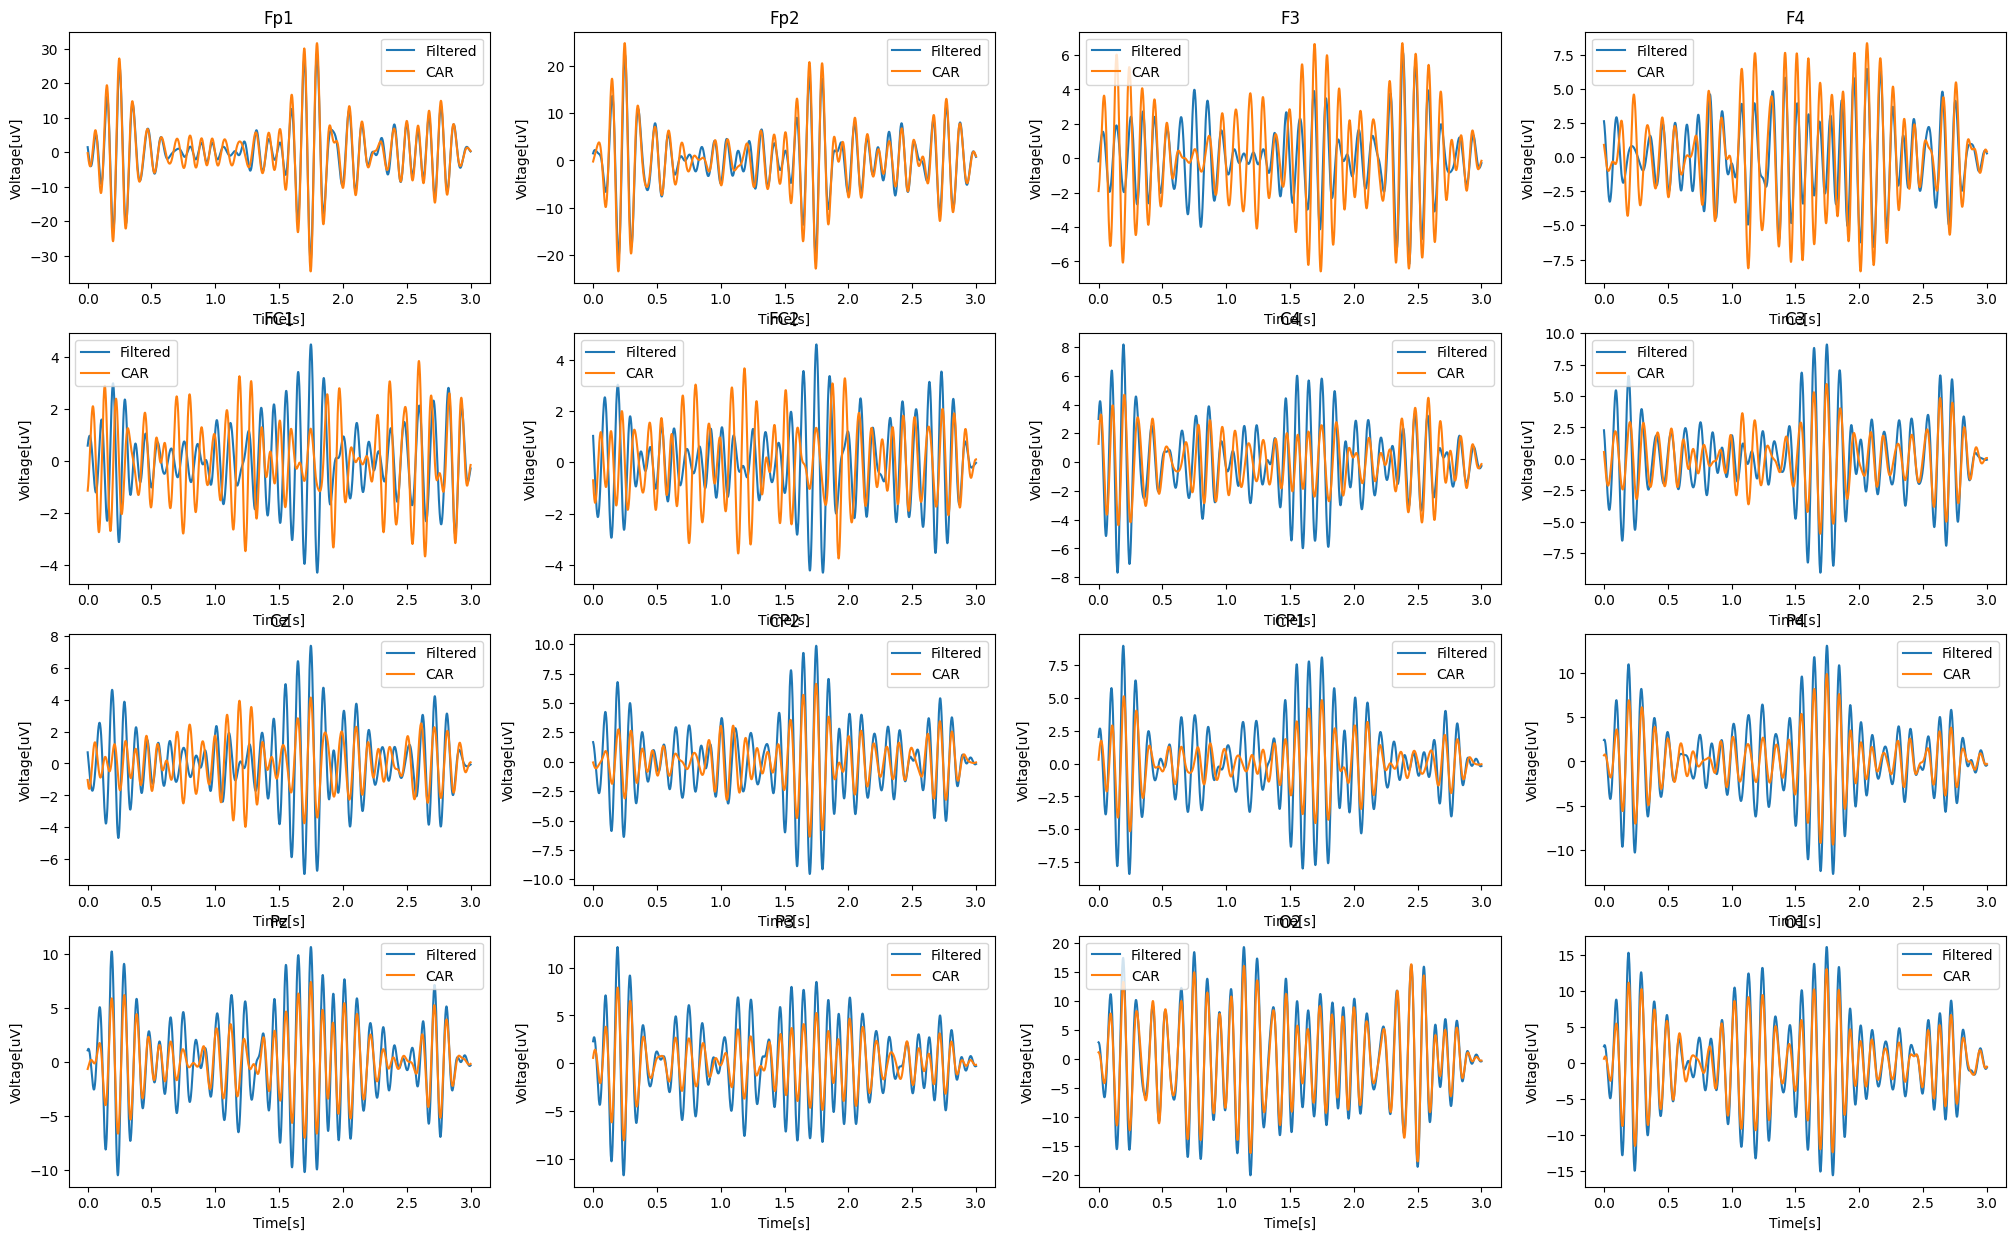

In [14]:
plt.figure(figsize=(25,15))
for idx,column in enumerate(eeg_window_filtered.columns):
  plt.subplot(4,4,idx+1)
  plt.plot(time,eeg_window_filtered[column],label='Filtered')
  plt.plot(time,eeg_car[column],label='CAR')
  plt.xlabel('Time[s]')
  plt.ylabel('Voltage[uV]')
  plt.title(column)
  plt.legend()

plt.show()

Interessante notar que em alguns canais a mudança foi muito grande (vide canais Fp1 e Fp2), enquanto que em outros a mudança já foi menos (como em O1 e O2). A aplicação de um filtro CAR acaba gerando distorções nos sinais, principalmente em regiões de melhor amplitude, por conta de um "preço" que temos que pagar pela remoção da interferência. No futuro, saberemos utilizar outros filtros espaciais que acabam diminuindo este "preço" a ser pago

Aviso: estudem média ponderada

# Mapa topográfico

Ok, este nome "mapa topográfico" assusta quando não sabemos (ou esquecemos) o que é. Mas calma que ele é nosso amigo e já vamos entender o porquê.

Porém, antes de chegar nele, precisamos calcular a potência média de cada canal.
Para isso, vamos utilizar a fórmula presente nos slides da aula 4-5

\begin{equation}
    P_{average} = \frac{1}{2N+1}\sum_{k=-N}^{N}(x[k])^2
\end{equation}

Sim, é para isso que salvamos lá em cima no parâmetro N a quantidade de amostras que cada canal vai ter. Além disso, como nosso sinal não existe para k<0 então nossa equação é na verdade

\begin{equation}
    P_{average} = \frac{1}{2N+1}\sum_{k=0}^{N}(x[k])^2
\end{equation}

In [15]:
eeg_sqrd = eeg_car.apply(np.square) # Elevar todos os pontos ao quadrado
eeg_power = eeg_sqrd.sum(axis=0) # Soma todos os valores em cada coluna
                                 # (calcula a energia de cada canal)
eeg_power = eeg_power.apply(lambda x: x/(2*N+1)) # Divide a energia de cada
                                                 # canal por 2N+1
print(type(eeg_power))
print(eeg_power.shape)
print(eeg_power)

<class 'pandas.core.series.Series'>
(16,)
Fp1    39.935011
Fp2    24.769729
F3      3.794463
F4      5.915558
FC1     1.111779
FC2     0.989923
C4      1.572533
C3      1.956116
Cz      1.076573
CP2     1.636949
CP1     1.327724
P4      3.867984
Pz      3.336880
P3      2.672979
O2     24.264983
O1     10.467188
dtype: float64


Essa parte é porque para utilizar as visualizações do MNE precisamos passar informações como: o tipo de cada canal (pode ser "eeg","meg","nirs",...), os nomes dos canais, qual a frequência de amostragem (porque é possível utilizar o MNE para fazer filtragem também), tipo de montagem dos sensores(a montagem dos sensores num MEG é diferente de num EEG).

In [16]:
ch_types = ['eeg'] * len(channels) # Temos 16 canais do tipo EEG

# Os nomes dos canais são os contidos na variável channels e a frequencia de
# amostragem sfreq vale FS (512 Hz)
information = mne.create_info(ch_names=channels, ch_types=ch_types, sfreq=FS)

# Iremos utilizar montagem seguindo o sistema 10-20
information.set_montage(mne.channels.make_standard_montage('standard_1020'))

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, FC1, FC2, C4, C3, Cz, CP2, CP1, P4, Pz, P3, O2, O1
 chs: 16 EEG
 custom_ref_applied: False
 dig: 19 items (3 Cardinal, 16 EEG)
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 16
 projs: []
 sfreq: 512.0 Hz
>

Pronto, agora que possuimos nossas informações no formato do MNE, vamos finalmente fazer nosso [mapa topográfico](https://mne.tools/dev/generated/mne.viz.plot_topomap.html). Este mapa mistura o conceito de mapa de calor (onde quanto mais intensa a cor, maior a potência naquela canal) com o conceito de topografia (quanto mais linhas próximas entre si, maior "o pico de potência"), tudo sendo mostrado ao longo da superfície do crânio.

Acredito que olhando o gráfico pode ser mais fácil de entender

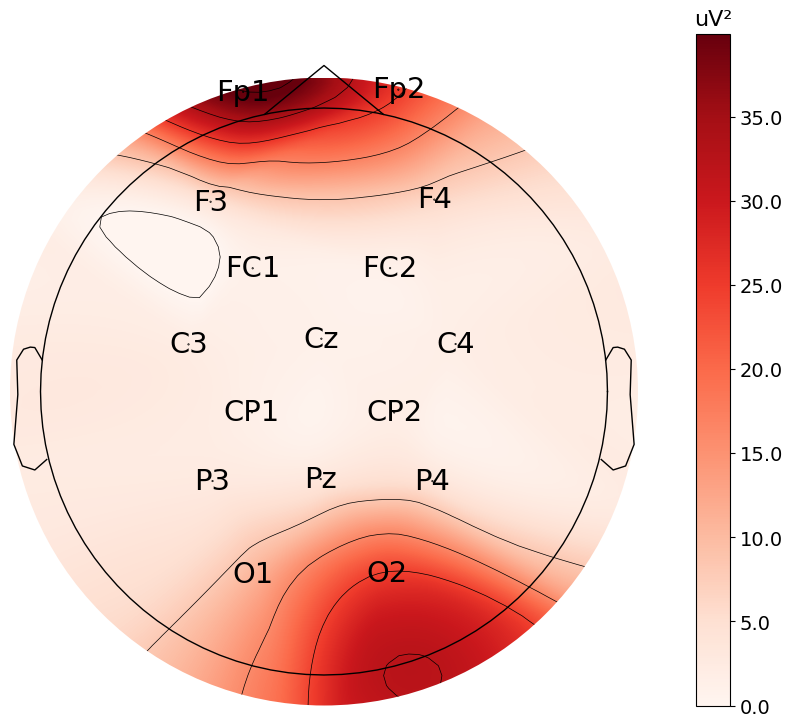

In [17]:
# Esta parte aqui é só para conseguir aumentar o tamanho do nome dos canais e o
# tamanho da figura
fig, axs = plt.subplots(1,1,figsize=(15,8))
matplotlib.rc('font', size=30)

im,cm = mne.viz.plot_topomap(eeg_power,information,extrapolate='head',axes=axs,
                             names=channels, contours=5, show=False)

# Aqui é só para criar uma barra de cor para indicar a escala de potência
# conforme a "temperatura" da cor
clb = fig.colorbar(im, format="%.1f")
clb.ax.tick_params(labelsize=14)
clb.ax.set_title("uV²",fontsize=16)

plt.show()

**[Atividade:] olhem como Fp1 tá com uma cor bem quente, seguido de O2. O que isso siginifica?**

# Atividades

Bem, agora que foram apresentados os conceitos, vamos praticar eles para deixarem de ser tão abstratos. Então

*   Crie o topoplot (é o mapa topográfico, gente) para essa mesma janela, mas agora utilizando um filtro Butterworth de 5ª ordem
*   Crie o topoplot da janela 8, mas utilizando um filtro Chebyshev de 3ª ordem com ripple de 3 dB
*   Crie o topoplot da janela 4, mas para ondas beta (utilize filtro Butterworth de 2ª ordem)
*   Crie o topoplot da janela 4, mas para ondas theta utilizando um filtro Bessel de 4ª ordem

Resolva cada item dentro das seções deles abaixo (vocês podem ir criando mais blocos de código e de texto, só respeitem as divisões de seções)



## Butterworth de 5ª ordem

## Chebyshev de 3ª ordem

## Ondas beta

## Ondas theta